In [2]:
import numpy as np
import pandas as pd 

import random
import sys
import matplotlib.pyplot as plt 
%matplotlib inline

sys.path.insert(1,'D:\\thesis-main\codes')
import time

from package.loadDb import *
from package.featureSelection_TENSORIZED import *
from package.featureSelection_TEMPORAL_PAGERANK import *
from package.featureSelection_SICE import *

from package.trmf import *
from package.trmf_regressor import *

from package.regressors import *


## KAGGLE

In [2]:
# import kaggle dataset
address = "..\database\kaggleDataFrame"
data_with_target= load_kaggle_dataframe(address+"\dataframes.csv")
# data_with_target=data_with_target.iloc[2000:4000]
data_without_target = data_with_target.drop(['DEMAND'],axis=1)
target=data_with_target.iloc[:,-1]
print("data with target size = ",data_with_target.shape )

data with target size =  (46968, 11)


## STOCK MARKET

In [ ]:
# # data with target column
# address = "..\database\stock market dataset"
# data_with_target=load_stock_market_dataframe(address+"\sample_normalized_with_target.csv")
# # data_with_target=data_with_target.iloc[:10000]
# data_without_target = data_with_target.drop(['TARGET'],axis=1)
# # data_without_target=data_with_target.iloc[:,:-1]
# target=data_with_target.iloc[:,-1]

## appliances+energy+prediction

In [3]:
address = "..\\database\\appliances+energy+prediction\\energydata_complete.csv"
data_with_target =load_energydata_complete_dataframe(address)
data_without_target = data_with_target.drop(['Appliances'],axis=1)
target=data_with_target.iloc[:,0]
# data_with_target

In [19]:
data_without_target[:618]

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,30,19.89,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,...,17.033333,45.530000,6.600000,733.500000,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433
2016-01-11 17:10:00,30,19.89,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,...,17.066667,45.560000,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195
2016-01-11 17:20:00,30,19.89,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,...,17.000000,45.500000,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668
2016-01-11 17:30:00,40,19.89,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,...,17.000000,45.400000,6.250000,733.800000,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389
2016-01-11 17:40:00,40,19.89,46.333333,19.200000,44.530000,19.790000,45.000000,18.890000,45.530000,17.200000,...,17.000000,45.400000,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-01-15 23:10:00,10,23.20,39.560000,22.390000,38.400000,21.100000,41.966667,21.500000,43.133333,20.666667,...,17.666667,45.900000,2.650000,760.683333,95.333333,3.000000,38.000000,1.983333,26.939715,26.939715
2016-01-15 23:20:00,0,23.10,39.626667,22.323333,38.500000,21.100000,41.933333,21.390000,43.326667,20.600000,...,17.730000,46.230000,2.600000,760.766667,95.666667,3.000000,36.000000,1.966667,35.735897,35.735897
2016-01-15 23:30:00,10,23.10,39.700000,22.323333,38.560000,21.100000,42.000000,21.390000,43.466667,20.463333,...,17.790000,46.430000,2.550000,760.850000,96.000000,3.000000,34.000000,1.950000,20.289525,20.289525


## gas+sensor+array+temperature+modulation

In [20]:
address='..\\database\\gas+sensor+array+temperature+modulation'
filenamelist=['20160930_203718.csv', '20161001_231809.csv', '20161003_085624.csv', '20161004_104124.csv', 
              '20161005_140846.csv', '20161006_182224.csv', '20161007_210049.csv', '20161008_234508.csv',
              '20161010_095046.csv', '20161011_113032.csv', '20161013_143355.csv', '20161014_184659.csv',
              '20161016_053656.csv']
# Assuming the file name is in the format "20160930_203718.csv"
filename = filenamelist[0]
data=load_temperature_modulation(address,filename)

data.head()


,CO (ppm),Humidity (%r.h.),Temperature (C),Flow rate (mL/min),Heater voltage (V),R1 (MOhm),R2 (MOhm),R3 (MOhm),R4 (MOhm),R5 (MOhm),R6 (MOhm),R7 (MOhm),R8 (MOhm),R9 (MOhm),R10 (MOhm),R11 (MOhm),R12 (MOhm),R13 (MOhm),R14 (MOhm)
Time (s),,,,,,,,,,,,,,,,,,,
2016-09-30 00:00:00.000,0.0,49.7534,23.7184,233.2737,0.8993,0.2231,0.6365,1.1493,0.8483,1.2534,1.4449,1.9906,1.3303,1.4480,1.9148,3.4651,5.2144,6.5806,8.6385
2016-09-30 00:00:00.309,0.0,55.8400,26.6200,241.6323,0.2112,2.1314,5.3552,9.7569,6.3188,9.4472,10.5769,13.6317,21.9829,16.1902,24.2780,31.1014,34.7193,31.7505,41.9167
2016-09-30 00:00:00.618,0.0,55.8400,26.6200,241.3888,0.2070,10.5318,22.5612,37.2635,17.7848,33.0704,36.3160,42.5746,49.7495,31.7533,57.7289,53.6275,56.9212,47.8255,62.9436
2016-09-30 00:00:00.926,0.0,55.8400,26.6200,241.1461,0.2042,29.5749,49.5111,65.6318,26.1447,58.3847,67.5130,68.0064,59.2824,36.7821,66.0832,66.8349,66.9695,50.3730,64.8363
2016-09-30 00:00:01.234,0.0,55.8400,26.6200,240.9121,0.2030,49.5111,67.0368,77.8317,27.9625,71.7732,79.9474,79.8631,62.5385,39.6271,68.1441,62.0947,49.4614,52.8453,66.8445


## gas+sensor+array+under+dynamic+gas+mixtures
### <!-- https://archive.ics.uci.edu/dataset/322/gas+sensor+array+under+dynamic+gas+mixtures -->

In [34]:
# address='..\\database\\gas+sensor+array+under+dynamic+gas+mixtures\\'
# file_path = 'ethylene_methane.txt'
# df = pd.read_csv(address+file_path, delim_whitespace=True)
# df.to_csv(address+"ethylene_methane.csv", index=False)

In [40]:

address='..\\database\\gas+sensor+array+under+dynamic+gas+mixtures\\'
filenamelist=["ethylene_CO.csv","ethylene_methane.csv"]
filename = filenamelist[0]
data=load_dynamic_gas_mixtures(address,filename)


,CO_conc_(ppm),Ethylene_conc_(ppm),sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16
Time_(seconds),,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00.000,0.0,0.0,-50.85,-1.95,-41.82,1.30,-4.07,-28.73,-13.49,-3.25,55139.95,50669.50,9626.26,9762.62,24544.02,21420.68,7650.61,6928.42
2020-01-01 00:00:00.010,0.0,0.0,-49.40,-5.53,-42.78,0.49,3.58,-34.55,-9.59,5.37,54395.77,50046.91,9433.20,9591.21,24137.13,20930.33,7498.79,6800.66
2020-01-01 00:00:00.010,0.0,0.0,-40.04,-16.09,-27.59,0.00,-7.16,-42.14,-12.52,-5.86,53960.02,49299.30,9324.40,9449.81,23628.90,20504.94,7369.67,6697.47
2020-01-01 00:00:00.030,0.0,0.0,-47.14,-10.57,-32.28,4.40,-11.22,-37.94,-7.16,-1.14,53047.71,48907.00,9170.64,9305.58,23101.66,20101.42,7285.13,6578.52
2020-01-01 00:00:00.040,0.0,0.0,-33.58,-20.79,-33.25,6.03,3.42,-34.22,-14.46,8.31,52700.28,48330.96,9073.64,9163.47,22689.54,19694.07,7156.74,6468.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01 11:41:27.510,0.0,0.0,1127.81,105.93,2117.39,2247.58,1207.59,1646.73,2089.97,2262.98,1061.70,1070.47,2570.33,2073.57,709.06,775.36,2513.75,1848.65
2020-01-01 11:41:27.520,0.0,0.0,1140.73,96.46,2105.93,2253.69,1216.39,1624.47,2073.57,2246.61,1063.89,1075.26,2580.88,2083.78,698.24,768.93,2511.20,1843.63
2020-01-01 11:41:27.530,0.0,0.0,1123.99,107.92,2111.18,2245.63,1215.36,1628.44,2085.45,2271.80,1059.31,1063.49,2583.20,2090.20,709.62,775.73,2510.18,1841.80


# RUN

In [24]:
#segment sizes
interval=600
testSize=int(.2*interval)
#energy of pca to compute number of components
tol=.89
testSize

120

In [25]:
#dictionary contains rmse of test set of each segment for all methods
dict_rmse={}
dict_runtime={}

PCA

In [26]:
counter=0
pca_list=[]
num_comp_list=[]
runtime=[]
# while counter+interval <= data_without_target.shape[0]:
for i in range(data_without_target.shape[0]//interval):
    start_index=i*interval
    end_index=start_index+interval

    datacut=data_with_target[start_index:end_index]
    X_datacut=datacut.iloc[:,:-1]
    Y_datacut=datacut.iloc[:,-1]
    # print(counter,X_datacut.shape)
    st = time.time()
    X_transformed,eigenvalues=compute_pca(X_datacut,num_comp=None)
    et = time.time()
    num_comp=energy(eigenvalues,tol)
    X_pca=X_transformed[:,:num_comp]
    
    pca_rmse=xgboost_reg_error(X_pca,Y_datacut,testSize)

    pca_list.append(pca_rmse)##########################
    num_comp_list.append(num_comp)##########################

    elapsed_time = et - st
    runtime.append(elapsed_time)
    

    # counter+=interval
    
dict_rmse['PCA']=pca_list
dict_runtime["PCA_runtime"]=runtime

In [27]:
num_comp_list

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 4,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 1]

TRMF

In [28]:
# trmf parameters..............................................
lags = [1,30]
# K = 4######### changes besed on pca energy
lambda_f = 1.
lambda_x = 1
lambda_w = 1.
alpha = 1000.
eta = 1.
max_iteration=10000
# num_comp=K

In [29]:
trmf_rmse_list=[]
runtime=[]

counter=0
i=0
# while counter+interval <= data_without_target.shape[0]:
for j in range(data_without_target.shape[0]//interval):
    start_index=j*interval
    end_index=start_index+interval
    
    K=num_comp_list[i]

    data=data_without_target.to_numpy().T

    data=data[:,start_index:end_index]
    target_cut=target.iloc[start_index:end_index]

    T_train = data.shape[1]
    st=time.time()#>>>>>>>>>>>>>>>>>>>>>>
    data_normalized =normalized_data(data, T_train, 0, normalize=True)

    model = trmf(lags, K, lambda_f, lambda_x, lambda_w, alpha, eta)
    model.fit(data_normalized, max_iter = max_iteration)
    et=time.time()#>>>>>>>>>>>>>>>>>>>>>>
    elapsed_time = et - st
    runtime.append(elapsed_time)

    # get reduced data
    new_features=model.X.T
    
    rmse=xgboost_reg_error(new_features,target_cut,testSize)
    
    trmf_rmse_list.append(rmse)
    # counter+=interval
    i=i+1
    print(i,K)
    print("----------------------------------------------------------------------------")
dict_rmse['trmf_rmse']=trmf_rmse_list
dict_runtime["TRMF_runtime"]=runtime


1 1
----------------------------------------------------------------------------
2 1
----------------------------------------------------------------------------
3 1
----------------------------------------------------------------------------
4 1
----------------------------------------------------------------------------
5 1
----------------------------------------------------------------------------
6 1
----------------------------------------------------------------------------
7 1
----------------------------------------------------------------------------
8 1
----------------------------------------------------------------------------
9 2
----------------------------------------------------------------------------
10 1
----------------------------------------------------------------------------
11 1
----------------------------------------------------------------------------
12 1
----------------------------------------------------------------------------
13 1
--------------------

TEMPORAL PAGE RANK FEATURE SELECTION

In [30]:
window_size_list=[2,3,5,7,10,30]#

In [31]:


dict_mse_tpr={}
dict_runtime_tpr={}
for window_size in window_size_list :
    method_list = []
    runtime=[]

    # counter=0
    i=0
    # while counter+interval <= data_without_target.shape[0]:
    for j in range(data_without_target.shape[0]//interval):
        start_index=j*interval
        end_index=start_index+interval

        num_comp=num_comp_list[i]

        datacut=data_with_target[start_index:end_index]
        X_datacut=datacut.iloc[:,:-1]
        Y_datacut=datacut.iloc[:,-1]


        st=time.time()#>>>>>>>>>>>>>>>>>>>>>>
        
        arr=create_graph_details(X_datacut,window_size)
        a=featureSelection_tpr(arr,X_datacut.shape[1],num_comp)
       
        et=time.time()#>>>>>>>>>>>>>>>>>>>>>>
        elapsed_time = et - st
        runtime.append(elapsed_time)


        mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)

        method_list.append(mse_tpr)
        #     print( "method_list",method_list)
        i=i+1
        # print(j)
        # print("----------------------------------------------------------------------------")
        # counter+=interval
    dict_mse_tpr["Temp-PR win={}".format(window_size)]=method_list
    dict_runtime_tpr["Temporal-PR win={}".format(window_size)]=runtime


dataframe_1 = pd.DataFrame(dict_mse_tpr)
dict_rmse['temp_PR_rmse']=list(dataframe_1.min(axis=1))
df_time_1=pd.DataFrame(dict_runtime_tpr)
dict_runtime["Temporal_pr_runtime"]=list(df_time_1.mean(axis=1))


C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_5484\3354977580.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)
C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_5484\3354977580.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)
C:\Users\User.MORADI-PC\AppData\Local\Temp\ipykernel_5484\3354977580.py:31: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mse_tpr=xgboost_reg_error(X_datacut[X_datacu

## STATIC PR


In [32]:
dict_mse_sice={}
dict_runtime_sice={}

for window_size in window_size_list:
    method_list = []
    runtime=[]

    # counter=0
    i=0
    # while counter+interval <= data_with_target.shape[0]:
    for j in range(data_without_target.shape[0]//interval):
        start_index=j*interval
        end_index=start_index+interval

        num_comp=num_comp_list[i]


        datacut=data_with_target[start_index:end_index]
        X_datacut=datacut.iloc[:,:-1]
        Y_datacut=datacut.iloc[:,-1]
        st=time.time()#>>>>>>>>>>>>>>>>>>>>>>

        selected_features_index=featureSelection(X_datacut,window_size)
        
        et=time.time()#>>>>>>>>>>>>>>>>>>>>>>
        elapsed_time = et - st
        runtime.append(elapsed_time)
        
        selected_data= X_datacut[X_datacut.columns[selected_features_index]].to_numpy()
        mse_sice=xgboost_reg_error(selected_data[:,:num_comp],Y_datacut,testSize)
        

        method_list.append(mse_sice)
        #     print( "method_list",method_list)
        i=i+1
        print(counter/interval)
        print("----------------------------------------------------------------------------")
        counter+=interval
    dict_mse_sice["sice win={}".format(window_size)]=method_list
    dict_runtime_sice["Static-PR win={}".format(window_size)]=runtime

dataframe_2 = pd.DataFrame(dict_mse_sice)
dict_rmse['static_PR_rmse']=list(dataframe_2.min(axis=1))
df_time_2=pd.DataFrame(dict_runtime_sice)
dict_runtime["Static_pr_runtime"]=list(df_time_2.mean(axis=1))

number of windows= 300 
size of windows = 2
[0.07360740691808004, 0.07337488896103084, 0.07367307608531186, 0.07367315310292351, 0.07367307901704621, 0.07367310735689975, 0.07367309503200736, 0.0736730975318392, 0.07367307473957922, 0.07367311342026563, 0.07367315293191726, 0.07367289283017714, 0.07367237704082491, 0.07367310342583773, 0.07367309775426087, 0.07367309470156963, 0.07367311860347173, 0.07367310479785248, 0.07367310008756449, 0.07367307161435328, 0.07366481269493635, 0.07367310271869994, 0.07367312557565295, 0.07367284426527337, 0.07367233128284406, 0.07361783527565391, 0.07345640540909852] [3, 10, 22, 16, 9, 5, 17, 13, 21, 18, 14, 7, 6, 15, 4, 2, 8, 19, 11, 23, 12, 24, 20, 25, 0, 26, 1]
0.0
----------------------------------------------------------------------------
number of windows= 300 
size of windows = 2
[0.07366032873222936, 0.07347085701364522, 0.07368179100285975, 0.07368186563649524, 0.07368185823213519, 0.07368197247511632, 0.07368187395093297, 0.073681894313616

<AxesSubplot: title={'center': 'num_comp=.'}, xlabel='dataframe segments', ylabel='RMSE'>

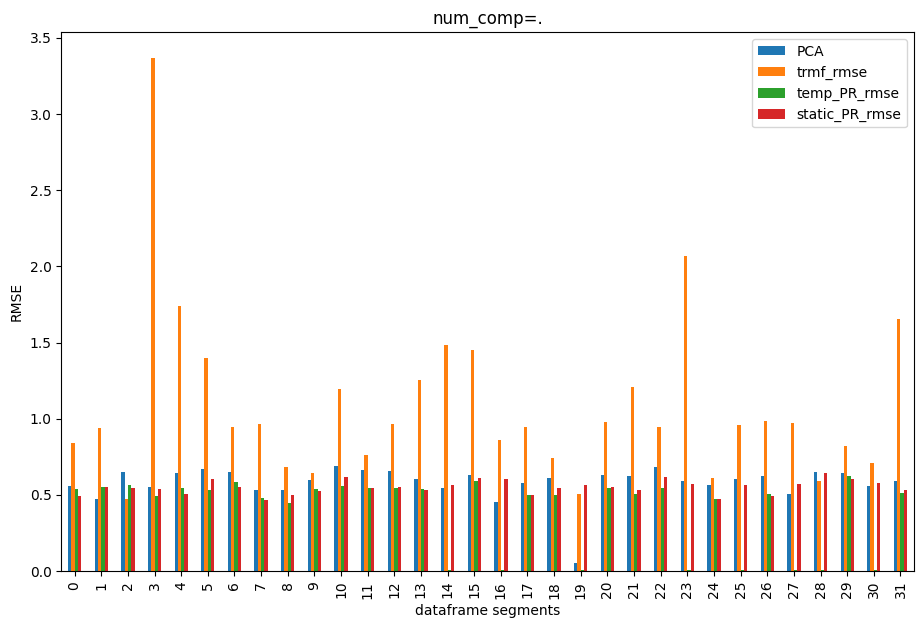

In [33]:
   
dataframe = pd.DataFrame(dict_rmse)
plt.rcParams["figure.figsize"] = [11,7]
dataframe.plot(kind="bar",title="num_comp={}".format("."),ylabel='RMSE',xlabel="dataframe segments")

<AxesSubplot: title={'center': '.'}, xlabel='dataframe segments', ylabel='Time'>

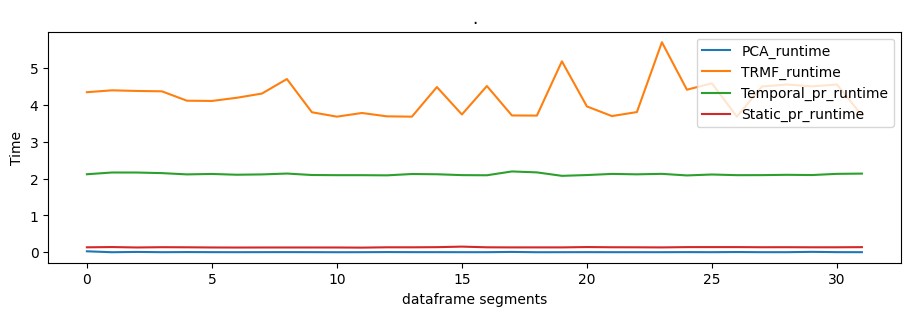

In [34]:
time_dataframe = pd.DataFrame(dict_runtime)
plt.rcParams["figure.figsize"] = [11,3]
time_dataframe.plot(kind="line",title="{}".format("."),ylabel='Time',xlabel="dataframe segments")


In [35]:
dataframe.mean()

PCA               0.581767
trmf_rmse         1.082977
temp_PR_rmse      0.399841
static_PR_rmse    0.550127
dtype: float64

In [36]:
num_comp_list

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 4,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 1]

In [41]:
dataframe

,PCA,trmf_rmse,temp_PR_rmse,static_PR_rmse
0,0.558393,0.841620,0.541361,0.489515
1,0.475564,0.938376,0.550956,0.550956
2,0.651562,0.471166,0.562094,0.547878
3,0.548786,3.370323,0.495052,0.535185
4,0.642257,1.738872,0.544208,0.503283
5,0.669327,1.396697,0.529744,0.602425
6,0.651623,0.942422,0.584359,0.553133
7,0.530634,0.964572,0.480097,0.467230
8,0.534813,0.683467,0.444060,0.496796
9,0.597764,0.640049,0.536778,0.522456


In [38]:
dataframe.loc['Var'] =list(dataframe.var())
dataframe.loc['Mean'] =list(dataframe.mean())
dataframe.loc['Min'] =list(dataframe.min())
dataframe.loc['Max'] =list(dataframe.max())

In [39]:
dataframe.head(30)


,PCA,trmf_rmse,temp_PR_rmse,static_PR_rmse
0,0.558393,0.841620,0.541361,0.489515
1,0.475564,0.938376,0.550956,0.550956
2,0.651562,0.471166,0.562094,0.547878
3,0.548786,3.370323,0.495052,0.535185
4,0.642257,1.738872,0.544208,0.503283
5,0.669327,1.396697,0.529744,0.602425
6,0.651623,0.942422,0.584359,0.553133
7,0.530634,0.964572,0.480097,0.467230
8,0.534813,0.683467,0.444060,0.496796
9,0.597764,0.640049,0.536778,0.522456


In [40]:
# name="kaggle-energy={}".format(tol)
# time_dataframe.to_excel("time-{}.xlsx".format(name))  
# dataframe.to_excel("RMSE-{}.xlsx".format(name))